Cleaned version of median houseprice notebook

In [265]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [266]:
postcodes_labelled = pd.read_csv("../flood_tool/resources/postcodes_labelled.csv")
postcodes_unlabelled = pd.read_csv("../flood_tool/example_data/postcodes_unlabelled.csv")
postcodes_missing = pd.read_csv("../flood_tool/example_data/postcodes_missing_data.csv")

sector_data = pd.read_csv("../flood_tool/resources/sector_data.csv")

crime_data = pd.read_csv("../flood_tool/resources/thinned_crime_data.csv")

soil_data = pd.read_csv("../flood_tool/resources/soil_details.csv")

Adding sector data to merged_dataset

In [267]:
# Splitting postcodeDistrict in sector_data into outercode and innercode
sector_data['postcodeDistrict'] = sector_data['postcodeSector'].apply(lambda x: x.split(' ')[0])
sector_data['innercode'] = sector_data['postcodeSector'].apply(lambda x: x.split(' ')[1])

In [268]:

# Separating the postcode into outercode and innercode
postcodes_labelled['postcodeDistrict'] = postcodes_labelled['postcode'].apply(lambda x: x.split(' ')[0])
postcodes_labelled['innercode'] = postcodes_labelled['postcode'].apply(lambda x: x.split(' ')[1])

In [269]:
# Grouping sector_data by postcodeDistrict, summing the households, numberofpostcodes and headcount only
sector_data_grouped = sector_data.groupby('postcodeDistrict').agg({'households': 'sum', 'numberOfPostcodeUnits': 'sum', 'headcount': 'sum'}).reset_index()

# Merging the grouped sector_data with the merged_postcode_data
merged_data = pd.merge(postcodes_labelled, sector_data_grouped, on='postcodeDistrict', how='left')

Adding crime data to merged dataset

In [270]:
from sklearn.neighbors import NearestNeighbors
# Takes input of number of suspects charged per policing area and the postcode data 
# Returns the number of suspects charged in each district appended to the postcode dataset
def postcode_nearest_station(policeArea, postcode):
    #define a knn model 
    knn_model = NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    
    #
    policeArea_coords = policeArea[['Latitude', 'Longitude']].values
    postcode_coords = postcode[['latitude', 'longitude']].values

    #
    knn_model.fit(policeArea_coords)

    #find the nearest policearea to each postcode
    distances, indices = knn_model.kneighbors(postcode_coords)
    print(distances.max())


    # 将最近 station 的信息添加到 postcode DataFrame
    postcode['nearest_policearea'] = policeArea.iloc[indices[:, 0]]['Reported by'].values
    postcode['Suspect Charged'] = policeArea.iloc[indices[:, 0]]['Suspect Charged'].values
    

    return postcode

In [271]:
suspects_charged = crime_data.groupby('Reported by').agg({'Suspect Charged': 'sum', 'Longitude': 'mean', 'Latitude': 'mean'}).reset_index()
suspects_charged = suspects_charged.sort_values(by='Suspect Charged', ascending=False)

import flood_tool as ft
merged_data['latitude'], merged_data['longitude'] = ft.geo.get_gps_lat_long_from_easting_northing(
    merged_data['easting'], merged_data['northing']
)

merged_data = postcode_nearest_station(suspects_charged, merged_data)
merged_data.head()

2.2434754875901053


,postcode,easting,northing,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,riskLabel,medianPrice,historicallyFlooded,postcodeDistrict,innercode,households,numberOfPostcodeUnits,headcount,latitude,longitude,nearest_policearea,Suspect Charged
0,BA1 1AL,374813,164571,Unsurveyed/Urban,20,River Avon,1240.0,Bath and North East Somerset,5,621800.0,1,BA1,1AL,19809.0,2178.0,42246.0,51.379625,-2.363284,Avon and Somerset Constabulary,964
1,BA1 1AN,375116,164500,Unsurveyed/Urban,20,River Avon,1550.0,Bath and North East Somerset,3,577900.0,0,BA1,1AN,19809.0,2178.0,42246.0,51.379000,-2.358926,Avon and Somerset Constabulary,964
2,BA1 1AR,375091,164454,Unsurveyed/Urban,20,River Avon,1540.0,Bath and North East Somerset,5,533300.0,1,BA1,1AR,19809.0,2178.0,42246.0,51.378585,-2.359282,Avon and Somerset Constabulary,964
3,BA1 1BG,375060,164969,Unsurveyed/Urban,30,River Avon,1450.0,Bath and North East Somerset,1,563600.0,0,BA1,1BG,19809.0,2178.0,42246.0,51.383215,-2.359763,Avon and Somerset Constabulary,964
4,BA1 1BH,375021,164930,Unsurveyed/Urban,30,River Avon,1410.0,Bath and North East Somerset,1,570800.0,0,BA1,1BH,19809.0,2178.0,42246.0,51.382862,-2.360321,Avon and Somerset Constabulary,964


Adding soiltypes to merged dataset

In [272]:
# Merging soiltypes with the merged_data
merged_data = pd.merge(merged_data, soil_data, on='soilType', how='left')
merged_data.head()

,postcode,easting,northing,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,riskLabel,medianPrice,...,Permeability Max(m�),Permeability Min(m�),Permeability mean(m�),Description,Bulk Density Min (g/cm�),Bulk Density Max (g/cm�),PSD min(mm),PSD max(mm),Organic soil,**Notes**
0,BA1 1AL,374813,164571,Unsurveyed/Urban,20,River Avon,1240.0,Bath and North East Somerset,5,621800.0,...,0.01,1.000000e-09,0.005,"mixed gravel, sand, clay",1.5,2.0,0.002,10.0,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
1,BA1 1AN,375116,164500,Unsurveyed/Urban,20,River Avon,1550.0,Bath and North East Somerset,3,577900.0,...,0.01,1.000000e-09,0.005,"mixed gravel, sand, clay",1.5,2.0,0.002,10.0,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
2,BA1 1AR,375091,164454,Unsurveyed/Urban,20,River Avon,1540.0,Bath and North East Somerset,5,533300.0,...,0.01,1.000000e-09,0.005,"mixed gravel, sand, clay",1.5,2.0,0.002,10.0,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
3,BA1 1BG,375060,164969,Unsurveyed/Urban,30,River Avon,1450.0,Bath and North East Somerset,1,563600.0,...,0.01,1.000000e-09,0.005,"mixed gravel, sand, clay",1.5,2.0,0.002,10.0,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
4,BA1 1BH,375021,164930,Unsurveyed/Urban,30,River Avon,1410.0,Bath and North East Somerset,1,570800.0,...,0.01,1.000000e-09,0.005,"mixed gravel, sand, clay",1.5,2.0,0.002,10.0,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."


In [273]:
merged_data.isnull().mean()

postcode                                                                       0.000000
easting                                                                        0.000000
northing                                                                       0.000000
soilType                                                                       0.000000
elevation                                                                      0.000000
nearestWatercourse                                                             0.376138
distanceToWatercourse                                                          0.000000
localAuthority                                                                 0.000000
riskLabel                                                                      0.000000
medianPrice                                                                    0.077525
historicallyFlooded                                                            0.000000
postcodeDistrict                

Nearest watercourse is over 30% null values, dropping feature.

In [274]:
# Dropping nearestwatercourse 
merged_data.drop('nearestWatercourse', axis=1, inplace=True)

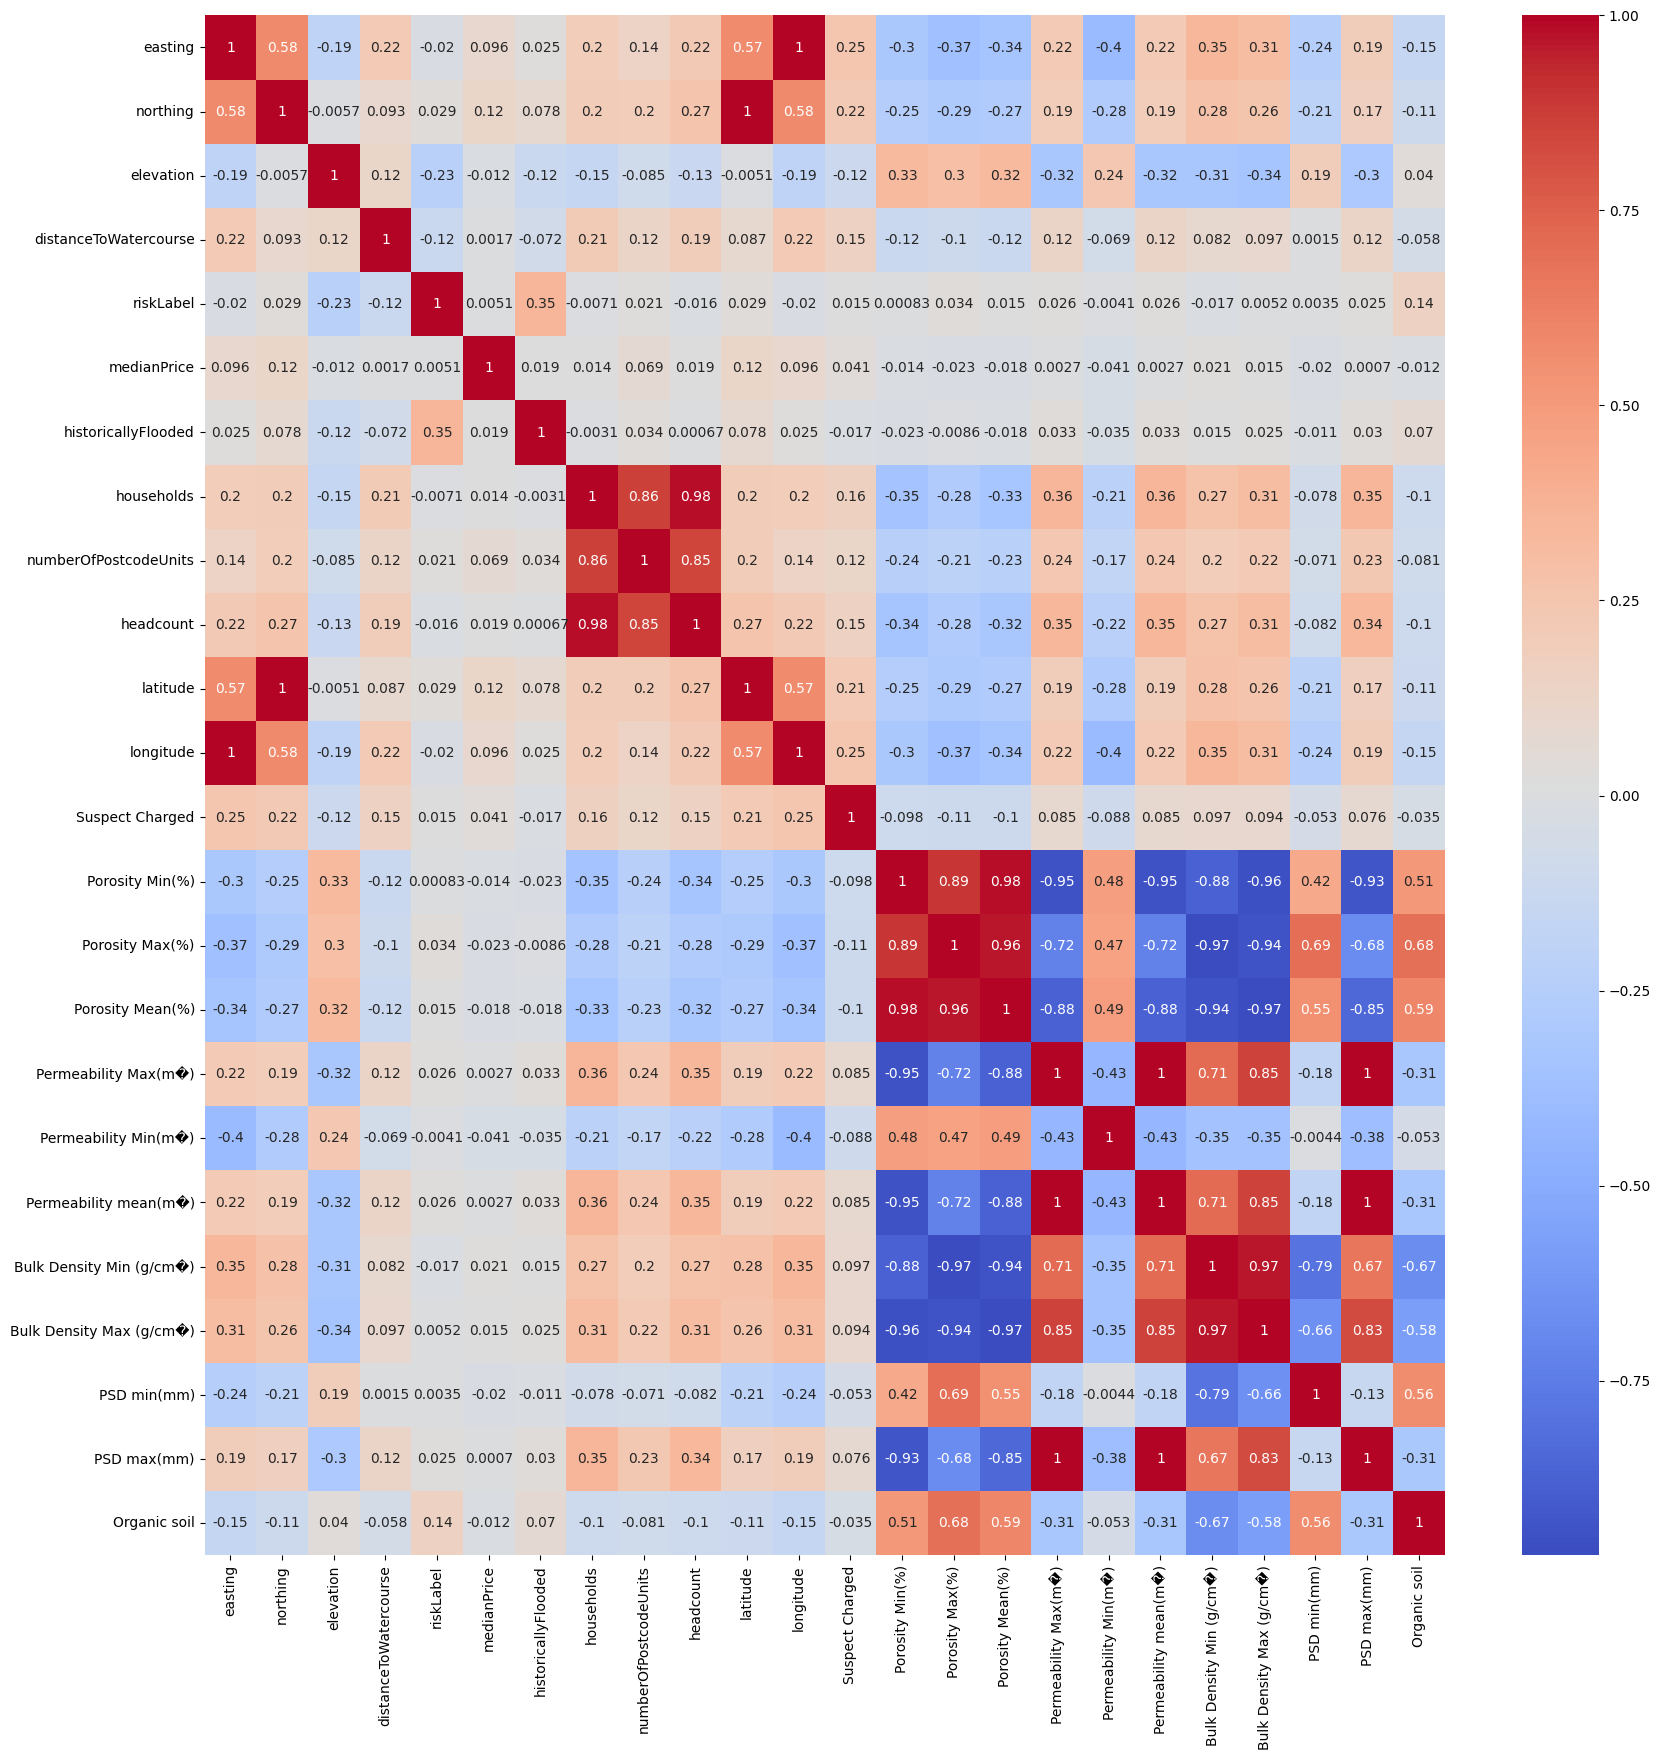

In [275]:
# Correlation matrix of numerical features
numerical_features = merged_data.select_dtypes(include=[np.number])
corr_matrix = numerical_features.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Due to high correlation, dropping lat long, Porosity Min(%)','Porosity Mean(%)','PSD max(mm)','Bulk Density Min (g/cm³)','Bulk Density Max (g/cm³)','Permeability mean(m²), 
households, headcount

In [276]:
print(merged_data.columns)

Index(['postcode', 'easting', 'northing', 'soilType', 'elevation',
       'distanceToWatercourse', 'localAuthority', 'riskLabel', 'medianPrice',
       'historicallyFlooded', 'postcodeDistrict', 'innercode', 'households',
       'numberOfPostcodeUnits', 'headcount', 'latitude', 'longitude',
       'nearest_policearea', 'Suspect Charged', 'Porosity Min(%)',
       'Porosity Max(%)', 'Porosity Mean(%)', 'Permeability category',
       'Permeability Max(m�)', 'Permeability Min(m�)', 'Permeability mean(m�)',
       'Description', 'Bulk Density Min (g/cm�)', 'Bulk Density Max (g/cm�)',
       'PSD min(mm)', 'PSD max(mm)', 'Organic soil',
       ' **Notes**                                                                 '],
      dtype='object')


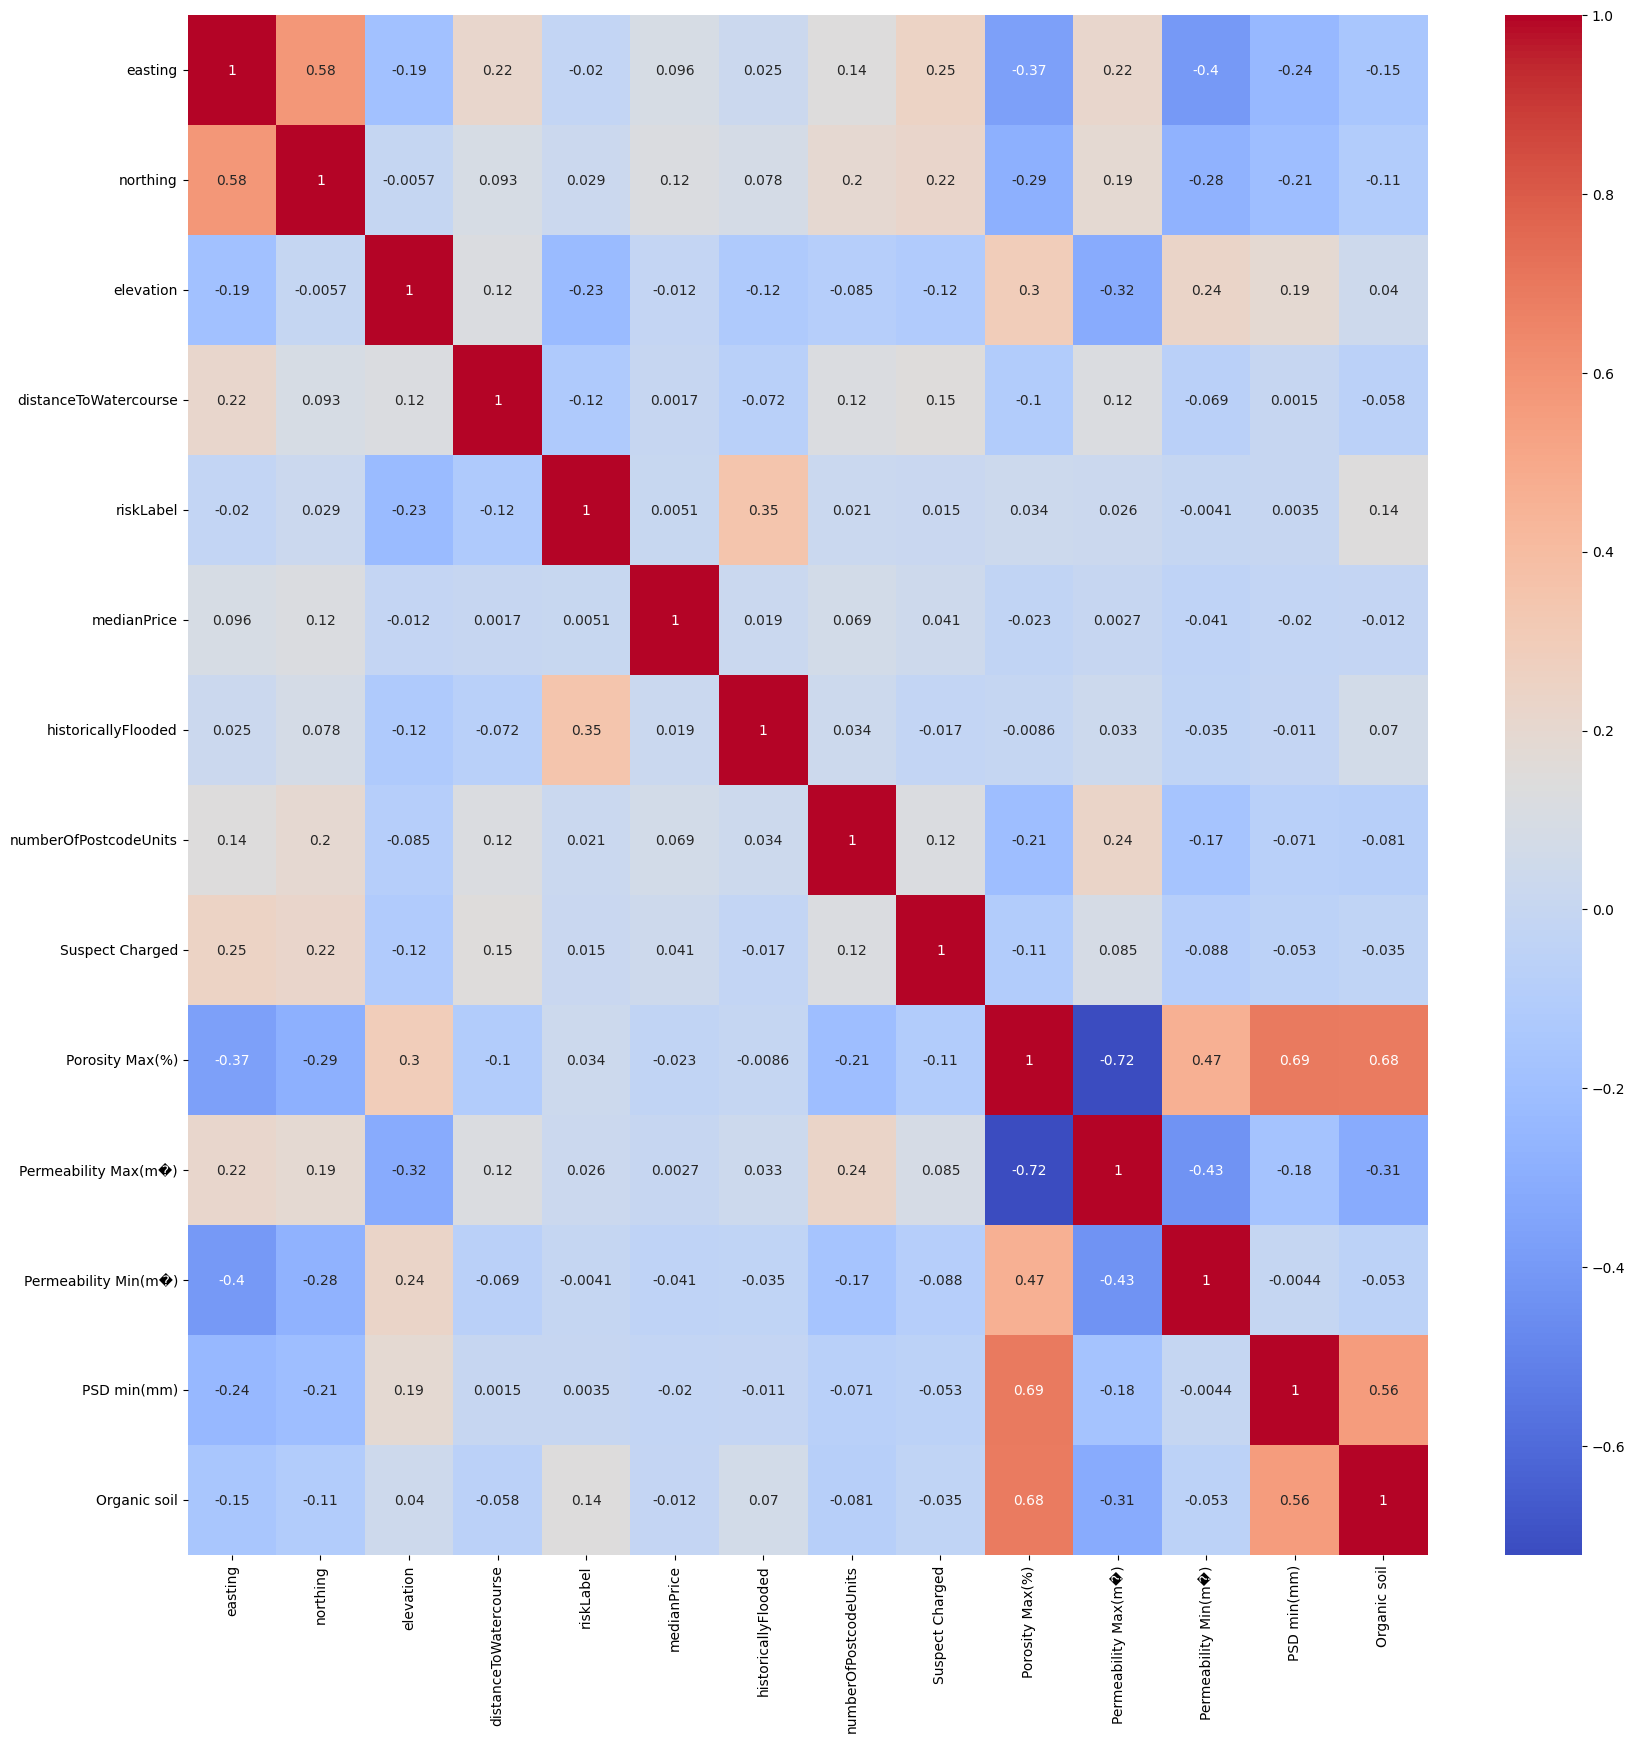

In [277]:
# Drop high correlation, dropping lat long, Porosity Min(%)','Porosity Mean(%)','PSD max(mm)','Bulk Density Min (g/cm³)','Bulk Density Max (g/cm³)','Permeability mean(m²), households, headcount

merged_data.drop(['latitude', 'longitude', 'Porosity Min(%)','Porosity Mean(%)','PSD max(mm)','Bulk Density Min (g/cm�)','Bulk Density Max (g/cm�)','Permeability mean(m�)','households', 'headcount'], axis=1, inplace=True)

# Correlation matrix of numerical features
numerical_features = merged_data.select_dtypes(include=[np.number])
corr_matrix = numerical_features.corr()

# Plotting the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [278]:
merged_data.drop(['historicallyFlooded','riskLabel','postcode', 'postcodeDistrict', 'innercode', 'soilType', 'nearest_policearea', ' **Notes**                                                                 '], axis=1, inplace=True)

In [279]:
print(merged_data.columns)

Index(['easting', 'northing', 'elevation', 'distanceToWatercourse',
       'localAuthority', 'medianPrice', 'numberOfPostcodeUnits',
       'Suspect Charged', 'Porosity Max(%)', 'Permeability category',
       'Permeability Max(m�)', 'Permeability Min(m�)', 'Description',
       'PSD min(mm)', 'Organic soil'],
      dtype='object')


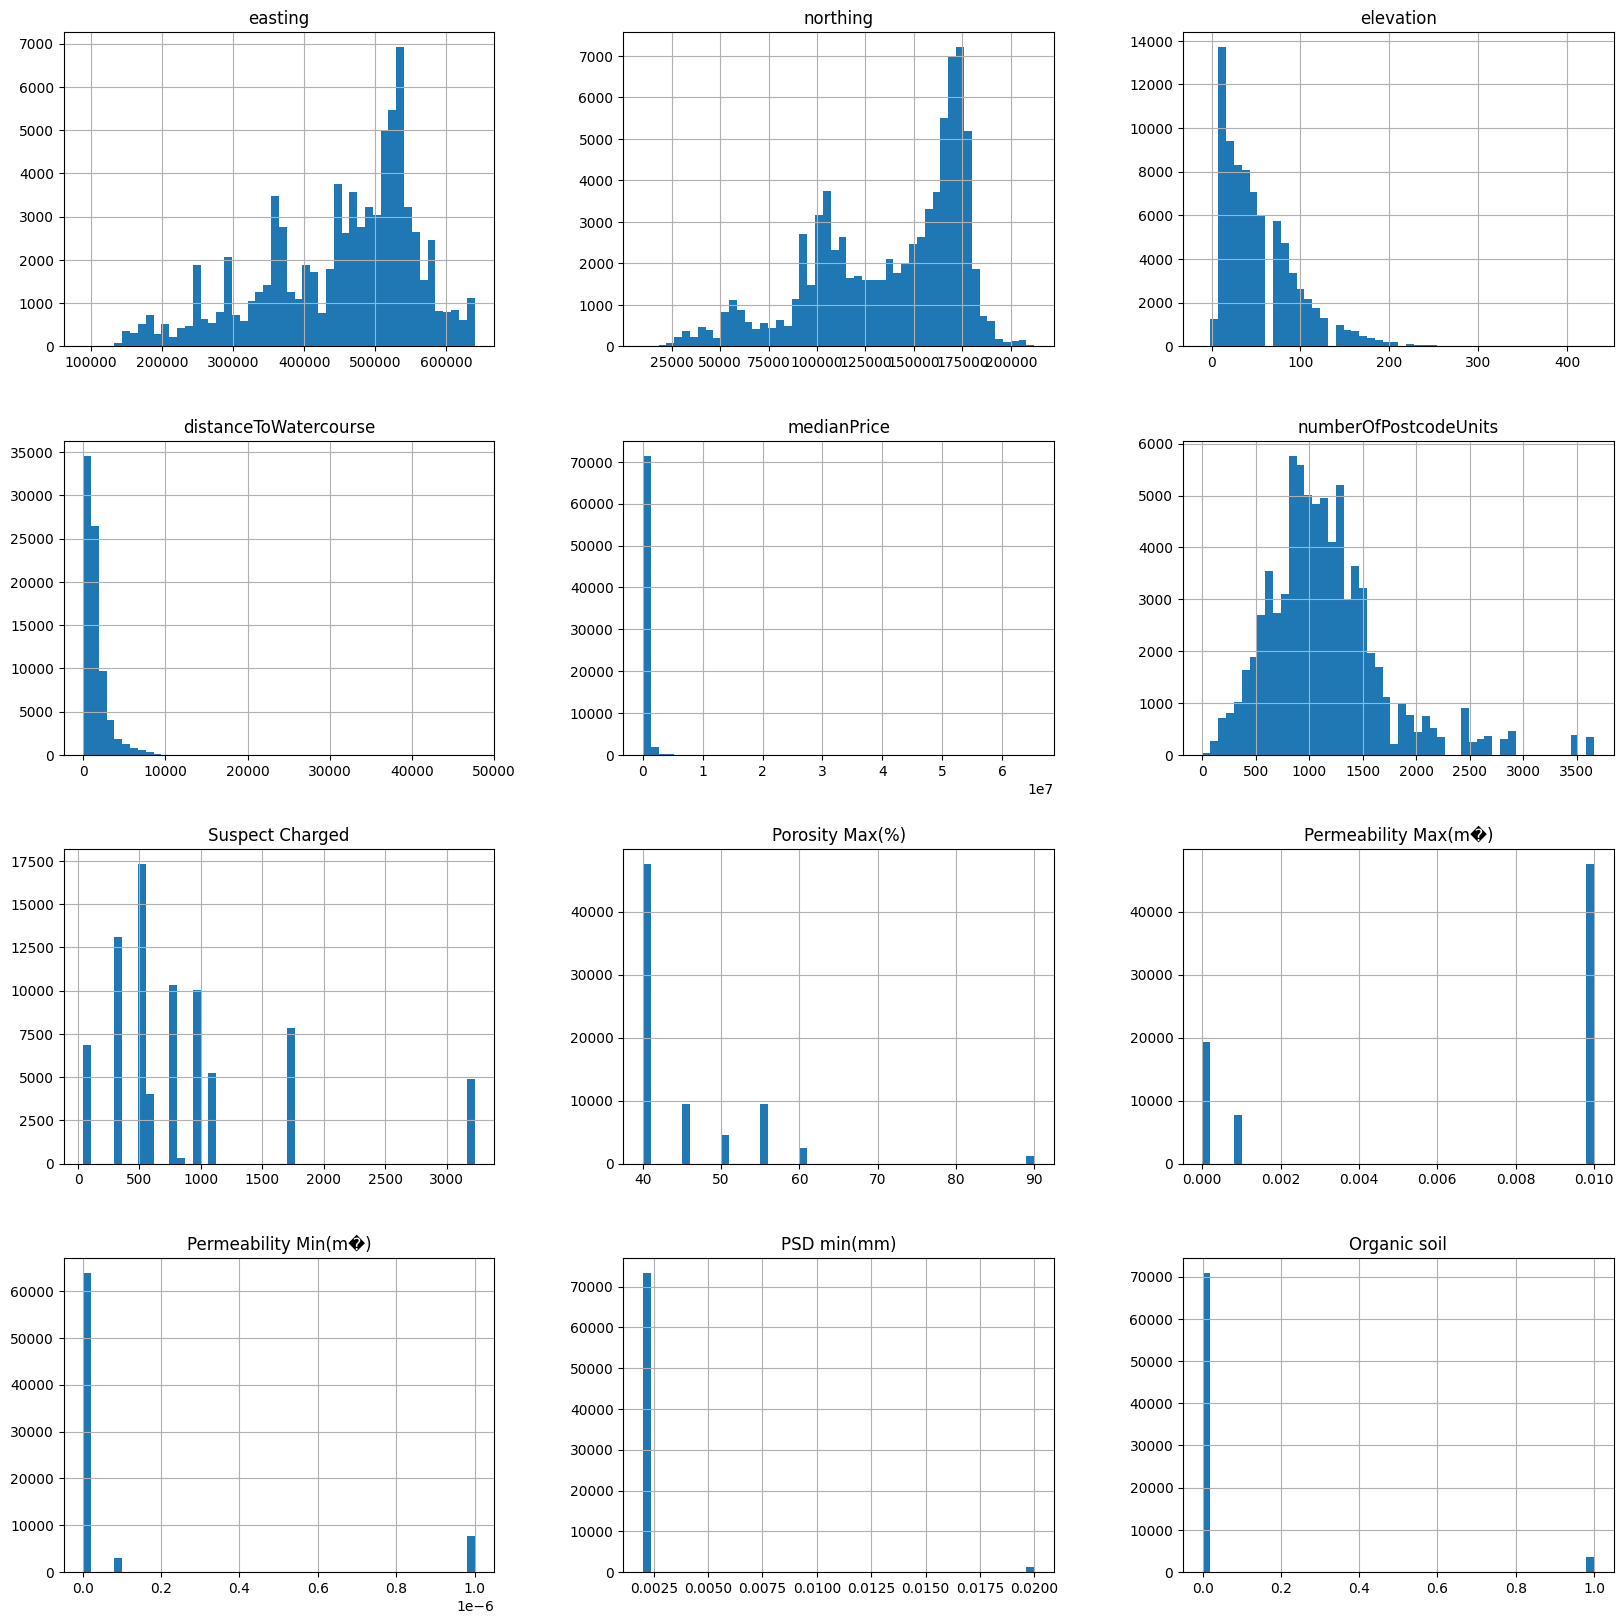

In [280]:
# Plotting histograms of numerical features
merged_data.hist(bins=50, figsize=(20, 20))
plt.show()

Number of postcodeunits is normal, everything else is skewed. Standard and minmax scaler should be used respectively

In [281]:
merged_data.head()


,easting,northing,elevation,distanceToWatercourse,localAuthority,medianPrice,numberOfPostcodeUnits,Suspect Charged,Porosity Max(%),Permeability category,Permeability Max(m�),Permeability Min(m�),Description,PSD min(mm),Organic soil
0,374813,164571,20,1240.0,Bath and North East Somerset,621800.0,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
1,375116,164500,20,1550.0,Bath and North East Somerset,577900.0,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
2,375091,164454,20,1540.0,Bath and North East Somerset,533300.0,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
3,375060,164969,30,1450.0,Bath and North East Somerset,563600.0,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
4,375021,164930,30,1410.0,Bath and North East Somerset,570800.0,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0


In [327]:
y = merged_data['medianPrice']
# dropping target feature values and postcode data and the last column#

X = merged_data.drop(['medianPrice'], axis=1)

In [328]:
X.head()

,easting,northing,elevation,distanceToWatercourse,localAuthority,numberOfPostcodeUnits,Suspect Charged,Porosity Max(%),Permeability category,Permeability Max(m�),Permeability Min(m�),Description,PSD min(mm),Organic soil
0,374813,164571,20,1240.0,Bath and North East Somerset,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
1,375116,164500,20,1550.0,Bath and North East Somerset,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
2,375091,164454,20,1540.0,Bath and North East Somerset,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
3,375060,164969,30,1450.0,Bath and North East Somerset,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
4,375021,164930,30,1410.0,Bath and North East Somerset,2178.0,964,40.0,Highly variable,0.01,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0


In [329]:
# Identifying numerical and categorical feature columns

numerical_features = X.select_dtypes(include=[np.number])
categorical_features = X.select_dtypes(include=[object])

print(numerical_features.columns)
print(categorical_features.columns)

Index(['easting', 'northing', 'elevation', 'distanceToWatercourse',
       'numberOfPostcodeUnits', 'Suspect Charged', 'Porosity Max(%)',
       'Permeability Max(m�)', 'Permeability Min(m�)', 'PSD min(mm)',
       'Organic soil'],
      dtype='object')
Index(['localAuthority', 'Permeability category', 'Description'], dtype='object')


In [330]:
# splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [331]:
# creating pipeline to preprocess the data
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer


# Preprocessing for numerical data

# Using minmax scaler for the other numerical data
minmax_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('minmax', MinMaxScaler())])

# Preprocessing for categorical data
onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

# Bundle preprocessing for numerical and categorical data

preprocessor = ColumnTransformer(
    transformers=[
        ('minmax', minmax_transformer, numerical_features.columns),
        ('onehot', onehot_transformer, categorical_features.columns),
    ])
preprocessor

ColumnTransformer(transformers=[('minmax',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('minmax', MinMaxScaler())]),
                                 Index(['easting', 'northing', 'elevation', 'distanceToWatercourse',
       'numberOfPostcodeUnits', 'Suspect Charged', 'Porosity Max(%)',
       'Permeability Max(m�)', 'Permeability Min(m�)', 'PSD min(mm)',
       'Organic soil'],
      dtype='object')),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['localAuthority', 'Permeability category', 'Description'], dtype='object'))])

In [332]:
# Impute NaN values in y_train
y_train = y_train.to_numpy().reshape(-1, 1)
imputer = SimpleImputer(strategy='mean')
y_train = imputer.fit_transform(y_train).ravel()

# Impute NaN values in y_test
y_test = y_test.to_numpy().reshape(-1, 1)
y_test = imputer.fit_transform(y_test).ravel()

# Impute NaN values in y_val
y_val = y_val.to_numpy().reshape(-1, 1)
y_val = imputer.fit_transform(y_val).ravel()

In [333]:
from sklearn.ensemble import RandomForestRegressor

# Implementing the best model for rf
rf_best_params = {
 'model__random_state': 42,
 'model__n_estimators': 140,
 'model__min_samples_split': 3,
 'model__min_samples_leaf': 1,
 'model__max_features': 'sqrt',
 'model__max_depth': 42,
 'model__bootstrap': True,
    }

rf_best = RandomForestRegressor(n_estimators=140, random_state=42, min_samples_split=3, min_samples_leaf=1, max_features='sqrt', max_depth=42, bootstrap=True)

# Bundle preprocessing and modeling code in a pipeline
rf_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_best)
                             ])

In [334]:
from xgboost import XGBRegressor

# Implementing the best model for xgb
xgb_best_params = {
    'model__n_estimators': 100,
    'model__max_depth': 25,
    'model__learning_rate': 0.01,
    'model__random_state': 42,
    'model__n_jobs': -1
    }

xgb_best = XGBRegressor(n_estimators=100, max_depth=25, learning_rate=0.01, random_state=42, n_jobs=-1)

# Bundle preprocessing and modeling code in a pipeline
xgb_best_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', xgb_best)
                             ])

In [335]:
from sklearn.ensemble import VotingRegressor

# Create individual models with the best parameters
model1 = rf_best_pipeline
model2 = xgb_best_pipeline

# Create the ensemble model
voting_model = VotingRegressor(estimators=[('rf', model1), ('xgb', model2)])

In [336]:
# Fit the ensemble model
voting_model.fit(X_train, y_train)

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('minmax',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('minmax',
                                                                                                MinMaxScaler())]),
                                                                               Index(['easting', 'northing', 'elevation', 'distanceToWatercourse',
       'numberOfPostcodeUnits', 'Suspect Charged', 'Porosity Max(%)',
       'Permeability Max(m�)', 'Permeability Min(m�)', 'PSD...
                                                           grow_policy=None,
                                                           importance_type=None,
                                                           interaction_constraints=None,
                                                           learning_rate=0.01,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=25,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=100,
                                                           n_jobs=-1,
                                                           num_parallel_tree=None,
                                                           random_state=42, ...))]))])

In [348]:
# Using cross validation to evaluate the model
from sklearn.model_selection import cross_val_score

# Evaluate the model using cross validation
scores = cross_val_score(voting_model, X_train, y_train, scoring='r2', cv=10)

In [ ]:
from sklearn.metrics import root_mean_squared_error

print("Voting Regressor cross-validation scores: ", scores)
print("Mean voting regressor cross-validation score: ", np.mean(scores))
print("Standard deviation of voting regressor cross-validation scores: ", np.std(scores))
print("Minimum voting regressor cross-validation score: ", np.min(scores))
print("Maximum voting regressor cross-validation score: ", np.max(scores))


print("Voting Regressor R^2 Score: ", voting_model.score(X_test, y_test))
print("Voting Regressor RMSE: ", root_mean_squared_error(y_test, voting_model.predict(X_test)))

Voting Regressor cross-validation scores:  [0.19055434 0.26916932 0.25142482 0.11779743 0.45793151 0.39604782
 0.19774864 0.20610746 0.31952628 0.03045858]
Mean voting regressor cross-validation score:  0.24367661957621262
Standard deviation of voting regressor cross-validation scores:  0.11968104415654607
Minimum voting regressor cross-validation score:  0.03045858288487735
Maximum voting regressor cross-validation score:  0.4579315124853113
Voting Regressor R^2 Score:  0.39752631399623617
Voting Regressor RMSE:  745304.8317048971


In [339]:
merged_postcode_data = pd.concat([postcodes_unlabelled, postcodes_missing], ignore_index=True)
merged_postcode_data.drop_duplicates(inplace=True)

# Separating the postcode into outercode and innercode
merged_postcode_data['postcodeDistrict'] = merged_postcode_data['postcode'].apply(lambda x: x.split(' ')[0])
merged_postcode_data['innercode'] = merged_postcode_data['postcode'].apply(lambda x: x.split(' ')[1])

In [340]:
# Adding the sector data to the merged_postcode_data
merged_postcode_data = pd.merge(merged_postcode_data, sector_data_grouped, on='postcodeDistrict', how='left')

In [341]:
# Using the voting model on the merged_postal data
# calculating the lat long for the merged_postcode_data
merged_postcode_data['latitude'], merged_postcode_data['longitude'] = ft.geo.get_gps_lat_long_from_easting_northing(
    merged_postcode_data['easting'], merged_postcode_data['northing']
)

merged_postcode_data = postcode_nearest_station(suspects_charged, merged_postcode_data)

merged_postcode_data = pd.merge(merged_postcode_data, soil_data, on='soilType', how='left')

2.2153336631426717


In [342]:
merged_postcode_data

,postcode,easting,northing,soilType,elevation,nearestWatercourse,distanceToWatercourse,localAuthority,postcodeDistrict,innercode,...,Permeability Max(m�),Permeability Min(m�),Permeability mean(m�),Description,Bulk Density Min (g/cm�),Bulk Density Max (g/cm�),PSD min(mm),PSD max(mm),Organic soil,**Notes**
0,PO9 5EA,472101,108419,Unsurveyed/Urban,40.0,NaN,1530.0,Havant,PO9,5EA,...,0.01000,1.000000e-09,0.005000,"mixed gravel, sand, clay",1.5,2.0,0.002,10.00,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
1,EX15 3XE,313905,113519,Luvisols,130.0,River Culm,310.0,Mid Devon,EX15,3XE,...,0.00001,1.000000e-08,0.000005,"clay, fine silt",1.3,1.6,0.002,0.05,0.0,Clay-enriched layers impede water movement. ...
2,PO14 4RJ,452325,106646,Unsurveyed/Urban,40.0,NaN,1270.0,Fareham,PO14,4RJ,...,0.01000,1.000000e-09,0.005000,"mixed gravel, sand, clay",1.5,2.0,0.002,10.00,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
3,SE24 9UX,532008,174437,Unsurveyed/Urban,20.0,River Thames,5290.0,Lambeth,SE24,9UX,...,0.01000,1.000000e-09,0.005000,"mixed gravel, sand, clay",1.5,2.0,0.002,10.00,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
4,BS20 9PR,346765,176083,Unsurveyed/Urban,10.0,NaN,640.0,North Somerset,BS20,9PR,...,0.01000,1.000000e-09,0.005000,"mixed gravel, sand, clay",1.5,2.0,0.002,10.00,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,BN21 4DE,559875,99669,Unsurveyed/Urban,NaN,NaN,NaN,Eastbourne,BN21,4DE,...,0.01000,1.000000e-09,0.005000,"mixed gravel, sand, clay",1.5,2.0,0.002,10.00,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
10993,KT18 5BA,520934,160353,Unsurveyed/Urban,50.0,NaN,1710.0,Epsom and Ewell,KT18,5BA,...,0.01000,1.000000e-09,0.005000,"mixed gravel, sand, clay",1.5,2.0,0.002,10.00,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
10994,BN50 9XQ,531040,104624,Unsurveyed/Urban,30.0,NaN,NaN,Brighton and Hove,BN50,9XQ,...,0.01000,1.000000e-09,0.005000,"mixed gravel, sand, clay",1.5,2.0,0.002,10.00,0.0,"Mixed materials (e.g., sand, gravel, clay); d..."
10995,BH22 8SG,408515,98030,NaN,20.0,NaN,950.0,Dorset,BH22,8SG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [343]:
merged_postcode_data.drop('nearestWatercourse', axis=1, inplace=True)

merged_postcode_data.drop(['latitude', 'longitude', 'Porosity Min(%)','Porosity Mean(%)','PSD max(mm)','Bulk Density Min (g/cm�)','Bulk Density Max (g/cm�)','Permeability mean(m�)'], axis=1, inplace=True)

merged_postcode_data.drop(['postcode', 'postcodeDistrict', 'innercode', 'soilType', 'nearest_policearea', ' **Notes**                                                                 '], axis=1, inplace=True)

In [344]:
merged_postcode_data

,easting,northing,elevation,distanceToWatercourse,localAuthority,households,numberOfPostcodeUnits,headcount,Suspect Charged,Porosity Max(%),Permeability category,Permeability Max(m�),Permeability Min(m�),Description,PSD min(mm),Organic soil
0,472101,108419,40.0,1530.0,Havant,20529.0,1478.0,50906.0,759,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
1,313905,113519,130.0,310.0,Mid Devon,9127.0,981.0,23819.0,964,45.0,Low to very low,0.00001,1.000000e-08,"clay, fine silt",0.002,0.0
2,452325,106646,40.0,1270.0,Fareham,14121.0,1158.0,33652.0,759,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
3,532008,174437,20.0,5290.0,Lambeth,8048.0,537.0,18479.0,3227,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
4,346765,176083,10.0,640.0,North Somerset,13436.0,1087.0,32907.0,964,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,559875,99669,NaN,NaN,Eastbourne,13856.0,1293.0,26270.0,506,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
10993,520934,160353,50.0,1710.0,Epsom and Ewell,7492.0,713.0,17684.0,302,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
10994,531040,104624,30.0,NaN,Brighton and Hove,NaN,NaN,NaN,506,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0
10995,408515,98030,20.0,950.0,Dorset,12722.0,874.0,27645.0,552,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [345]:
# Predicting the medianPrice using the voting model
merged_postcode_data['predicted medianPrice'] = voting_model.predict(merged_postcode_data)

merged_postcode_data.head()

,easting,northing,elevation,distanceToWatercourse,localAuthority,households,numberOfPostcodeUnits,headcount,Suspect Charged,Porosity Max(%),Permeability category,Permeability Max(m�),Permeability Min(m�),Description,PSD min(mm),Organic soil,predicted medianPrice
0,472101,108419,40.0,1530.0,Havant,20529.0,1478.0,50906.0,759,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0,273421.747098
1,313905,113519,130.0,310.0,Mid Devon,9127.0,981.0,23819.0,964,45.0,Low to very low,0.00001,1.000000e-08,"clay, fine silt",0.002,0.0,331191.229538
2,452325,106646,40.0,1270.0,Fareham,14121.0,1158.0,33652.0,759,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0,366334.570123
3,532008,174437,20.0,5290.0,Lambeth,8048.0,537.0,18479.0,3227,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0,958515.436012
4,346765,176083,10.0,640.0,North Somerset,13436.0,1087.0,32907.0,964,40.0,Highly variable,0.01000,1.000000e-09,"mixed gravel, sand, clay",0.002,0.0,440403.882613


In [346]:
# Output as csv
merged_postcode_data.to_csv('predicted_medianPrice.csv', index=False)